<a href="https://colab.research.google.com/github/Alijgh003/StyleMind-GNN/blob/main/StyleMind_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import copy
import pandas as pd

In [2]:
torch_version = str(torch.__version__)
# scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# !pip install torch-scatter -f $scatter_src
# !pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
datasets_path = "/content/drive/MyDrive/StyleMind-GNN"

In [5]:
from os import path

In [6]:
import pandas as pd
items = pd.read_csv(path.join(datasets_path, "new_items.csv"))
items.set_index("ID")

,Unnamed: 0,index,url_name,description,catgeories,title,related,category_id,semantic_category,name_len
ID,,,,,,,,,,
211990161,0,0,neck print chiffon plus size,NaN,NaN,NaN,NaN,3,tops,28
183179503,1,1,christian pellizzari floral jacquard trousers,Gold and black silk blend floral jacquard trou...,"[""Women's Fashion"", 'Clothing', 'Pants', 'Chri...",Christian Pellizzari floral jacquard trousers,"['Floral pants', 'Grey pants', 'Print pants', ...",2,bottoms,45
152771755,2,2,natures jewelry stainless steel not,NaN,NaN,NaN,NaN,11,jewellery,35
190445143,3,3,balmain women high waist flared,Decorative gold colored buttons with lion deta...,"[""Women's Fashion"", 'Clothing', 'Pants', 'Balm...",Balmain Women High Waist Flared Knit Pants,"['Balmain', 'Flared pants', 'High-waisted pant...",2,bottoms,31
211444470,4,4,acler orson high waist belted,This Acler Orson High Waist Belted Short featu...,"[""Women's Fashion"", 'Clothing', 'Shorts', 'Mar...",Acler Orson High Waist Belted Short,"['Short shorts', 'High-waisted shorts', 'High ...",2,bottoms,29
...,...,...,...,...,...,...,...,...,...,...
108411005,251003,251003,arnica embellished hand painted skirt,Shop Stella Jean in our expertly curated in-se...,"[""Women's Fashion"", 'Clothing', 'Skirts', 'Kne...",Arnica Embellished Hand Painted Skirt,"['Red skirt', 'Embellished skirt']",2,bottoms,37
212452593,251004,251004,thom browne little boy knitted,NaN,NaN,NaN,NaN,4,outerwear,30
208651882,251005,251005,colorful vortex print shawl scarf,NaN,NaN,NaN,NaN,8,scarves,33


#Utils

##Histoagram

In [7]:
def plot_histogram(output_tensor,title):
  output_numpy = output_tensor.detach().numpy()

  plt.hist(output_numpy, bins=30, edgecolor='black', alpha=0.7)
  plt.xlabel('Output Values')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.show()

##Free Cuda_Memory

In [8]:
import gc

def free_cuda_memory(model):
  model = model.cpu()
  gc.collect()
  torch.cuda.empty_cache()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
x = torch.load(path.join(datasets_path, "items_img2vec.pth")).to(device)
x, x.shape

In [ ]:
x.dtype ,x.shape

In [ ]:
edge_indices_path = path.join(datasets_path, "dataset", "polyvore_outfits", "nondisjoint")

In [ ]:
train_edge_index = torch.load(path.join(edge_indices_path, "train_edge_index.pth"))
test_edge_index = torch.load(path.join(edge_indices_path, "test_edge_index.pth"))
valid_edge_index = torch.load(path.join(edge_indices_path, "valid_edge_index.pth"))

In [ ]:
def get_node_embedding_with_mask_meaningless_edge_index_elements(x, edge_index):
    mask = torch.where(edge_index==-1, torch.tensor(0), torch.tensor(1)).unsqueeze(-1)
    r = x[edge_index] * mask
    return r

In [ ]:
train_edge_index.shape, valid_edge_index.shape, test_edge_index.shape

In [ ]:
negative_train_edge_index = torch.load(path.join(edge_indices_path,"negative_train_edge_index.pth"))
valid_negative_samples = torch.load(path.join(edge_indices_path, "negative_valid_edge_index.pth"))
test_negative_samples = torch.load(path.join(edge_indices_path, "negative_test_edge_index.pth"))

negative_train_edge_index.shape , valid_negative_samples.shape, test_negative_samples.shape

In [ ]:
def build_edge_indices_with_groups(edge_index_tensor_by_groups):
  if(edge_index_tensor_by_groups.shape[0]>0):
    result = torch.cat([edge_index_tensor_by_groups[i] for i in range(edge_index_tensor_by_groups.shape[0])],dim=-1)
    result = result[:,torch.where(result[0]>-1)[0]]
    return result
  else:
    return torch.randn((2, 1))

In [ ]:
def build_edge_indices_and_indices_with_groups(edge_index_tensor_by_groups):
  if(edge_index_tensor_by_groups.shape[0]>0):
    edge_indices = torch.cat([edge_index_tensor_by_groups[i] for i in range(edge_index_tensor_by_groups.shape[0])],dim=-1)
    indices = torch.cat([torch.full((edge_index_tensor_by_groups[i].shape[-1],), i) for i in range(edge_index_tensor_by_groups.shape[0])], dim=-1)
    indices = indices[edge_indices[0]>=0].view(-1,1)
    edge_indices = edge_indices[edge_indices>=0].view(2,-1)
    return edge_indices, indices
  else:
    return torch.randn((2, 1)), torch.randn((2,1))

In [99]:
def calculate_compatiblity_score(x,edge_indices, indices):
  target = torch.zeros((indices.max()+1,1)).to(device)
  y = x[edge_indices]
  y = (y[0] * y[1]).sum(dim=-1,keepdim=True)
  target.scatter_reduce_(0, index=indices, src=y, reduce="mean",include_self=False)
  return target.squeeze()

In [100]:
edge_indices, indices = build_edge_indices_and_indices_with_groups(train_edge_index[:100])
tar = calculate_compatiblity_score(x, edge_indices.to(device), indices.to(device))
tar.shape

tensor(427.7625, device='cuda:0')


torch.Size([100])

In [96]:
(indices==1).sum()

tensor(21)

In [72]:
tar

tensor([404.6009, 427.7625, 480.8698, 341.4810, 452.5041, 413.1764, 398.5618,
        395.4159, 352.3990, 446.9307, 396.9903, 489.1017, 364.2803, 258.2651,
        410.2933, 397.9751, 383.9202, 443.3247, 385.6469, 335.5515, 284.6152,
        383.1713, 374.3119, 369.2644, 418.0545, 352.2534, 341.7857, 390.7267,
        433.1676, 472.7012, 375.0181, 362.2078, 341.8579, 384.6054, 366.9610,
        414.3997, 308.2027, 391.2690, 431.0272, 328.0490, 385.3138, 375.8770,
        483.3997, 341.4896, 339.0242, 368.8496, 338.8096, 391.5097, 401.6982,
        420.7907, 358.8733, 480.6539, 452.4607, 418.7970, 317.2959, 433.9438,
        444.6258, 451.1752, 412.4218, 431.7679, 349.6571, 327.1309, 402.4774,
        461.2579, 389.7227, 567.7840, 429.4183, 402.5058, 420.1568, 359.9826,
        429.9524, 502.1635, 378.3183, 359.7645, 434.6635, 373.9522, 378.2859,
        446.8382, 405.7188, 492.7838, 444.0326, 429.3881, 404.2158, 419.1068,
        385.0469, 418.8496, 360.8320, 413.1811, 414.3415, 363.13

In [81]:
res = get_node_embedding_with_mask_meaningless_edge_index_elements(x, train_edge_index[:100].to(device))
# (res>=0).sum(dim=(-1,-2)).shape
# (res[:,0] * res[:,1]).sum(dim=(-1,-2)).shape
print((res[:,0] * res[:,1]).shape)
res = (res[:,0] * res[:,1]).sum(dim=(-1,-2)) / ((train_edge_index[:100])[:,:1,:]>=0).sum(dim=(-1,-2)).to(device)
res
# res.shape

torch.Size([100, 171, 2048])


tensor([419.0509, 448.1322, 498.0437, 350.9666, 482.6711, 432.8515, 464.9888,
        421.7769, 387.6389, 462.8926, 415.8946, 512.3921, 370.9036, 516.5302,
        437.6462, 405.2111, 409.5149, 472.8797, 411.3566, 351.5302, 313.0767,
        408.7160, 387.6801, 406.1909, 557.4059, 387.4788, 398.7500, 429.7993,
        505.3622, 519.9713, 412.5199, 386.3549, 376.0437, 410.2457, 380.0667,
        442.0264, 322.8790, 417.3535, 459.7622, 382.7239, 399.0750, 400.9355,
        506.4188, 375.6386, 372.9266, 386.4139, 361.3969, 417.6104, 420.8268,
        448.8435, 382.7982, 497.8201, 474.0064, 460.6767, 370.1786, 477.3383,
        489.0885, 526.3711, 427.1512, 452.3283, 366.3075, 381.6527, 442.7252,
        483.2226, 408.2809, 605.6362, 472.3602, 416.8810, 435.1624, 419.9797,
        458.6159, 552.3799, 396.3334, 376.8961, 478.1298, 391.7595, 441.3335,
        468.1162, 432.7667, 542.0621, 488.4358, 472.3268, 431.1634, 428.4202,
        449.2213, 438.7948, 396.9152, 440.7265, 455.7756, 376.10

In [43]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [19]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv,MessagePassing
from torch_geometric.utils import to_undirected
from torch.utils.data import DataLoader, TensorDataset


import torch.optim as optim

In [20]:
class MyGCNMLP(MessagePassing):
  def __init__(self,in_channels, out_channels, bias):
    super(MyGCNMLP, self).__init__()

    self.lin = torch.nn.Linear(in_channels, out_channels, bias)


  def forward(self, x, edge_index):
    return self.lin(x)

In [21]:
class StyleMindGCN(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels ,number_of_layers, model_type="GCN" , dropout=0.5, learning_margin=False):
    super(StyleMindGCN,self).__init__()

    self.convs = torch.nn.ModuleList([self.get_model(model_type)(in_channels if i==0 else hidden_channels,hidden_channels if i<number_of_layers-1 else out_channels, bias=False if i<number_of_layers-1 else True) for i in range(number_of_layers)])
    self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_channels) for i in range(number_of_layers-1)])

    self.learning_margin = learning_margin
    if self.learning_margin:
      self.final_prediction_margin = torch.nn.Parameter(torch.tensor(0.0))
    else:
      self.final_prediction_margin = torch.tensor(0.0)

    self.dropout = dropout


  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()
    for bn in self.bns:
        bn.reset_parameters()


  def get_model(self, model_type):
    if(model_type=="GAT"):
      return GATConv
    elif(model_type=="MLP"):
      return MyGCNMLP

    else:
      return GCNConv

  def forward(self, x, edge_index, outfits_edge_indices,outfits_indices):
    # x is the tensor of node_features (i.e. ResNet representation of each image of each garment)
    # edge_index is the (2, |E|) to represent edges between garments
    # outfits_edge_indices is 2 dim tensors with shape of (2,|number_of_pairs|)
    # outfits_indices is 2 dim tensors with shape of (|number_of_pairs|, 1)
    edge_index = to_undirected(edge_index)

    for conv, bn in zip(self.convs[:-1], self.bns):
      x = conv(x, edge_index)
      x = bn(x)
      x = F.relu(x)
      x = F.dropout(x, self.dropout)

    x = self.convs[-1](x,edge_index)

    o = calculate_compatiblity_score(x, outfits_edge_indices,outfits_indices)

    return x, o+self.final_prediction_margin


In [22]:
def train(model, x, edge_index, outfits_edge_indices,outfits_indices, labels, optimizer, loss_fn):
  model.train()
  optimizer.zero_grad()
  embds,o = model(x, edge_index, outfits_edge_indices,outfits_indices)

  loss = loss_fn(o, labels)
  loss.backward()

  optimizer.step()

  return loss.item()

In [23]:
@torch.no_grad()
def test(model, x, edge_index, outfits_edge_indices,outfits_indices, labels, decision_boundary=0.5):
  model.eval()

  embds,o = model(x, edge_index, outfits_edge_indices,outfits_indices)
  o = torch.sigmoid(o)
  o_pred = torch.where(o>=decision_boundary, torch.tensor(1), torch.tensor(0))

  acc = (o_pred==labels).float().sum() / o_pred.shape[0]

  return  acc

In [24]:
in_channels = x.shape[-1]
hidden_channels = 128
out_channels = 128
lr = 0.01
number_of_layers = 1
dropout = 0

In [25]:
model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=True).to(device)

In [26]:
NUM_EPOCHS = 500

# TODO:
- [x] splitting train dataset to two part
      - message_passing
      - labels
- [x] negative sampling  
  naive negative sampling: We just have randomly selected
    8 nodes to combine(2,nodes) to create some negative samples

In [27]:
%%time
def split_train_data(train_edge_index, diameter=5):
  edge_nums =  train_edge_index.shape[0]
  random_permutation = torch.randperm(edge_nums)
  eval_outfits = train_edge_index[random_permutation[:edge_nums//diameter]]
  message_passing_edges = build_edge_indices_with_groups(train_edge_index[random_permutation[edge_nums//diameter:]])
  return eval_outfits, message_passing_edges

a = split_train_data(train_edge_index)
[value.shape for  value in a]

CPU times: user 225 ms, sys: 159 ms, total: 384 ms
Wall time: 394 ms


[torch.Size([10661, 2, 171]), torch.Size([2, 549645])]

# Naive negative sampling

In [28]:
%%time
import torch
import itertools

def create_random_negative_samples(num_set, num_samples, num_garment, padding_size):
  combinations = [[list(itertools.combinations(torch.randperm(x.shape[0])[:num_garment].tolist(), 2)) for i in range(num_samples)] for j in range(num_set)]

  tensor = torch.tensor(combinations).transpose(-1,-2)
  tensor = torch.cat((tensor.flip(-2), tensor), dim=-1)
  result = torch.full((num_set, num_samples, 2, padding_size), -1)
  result[:,:,:,:tensor.shape[-1]] = tensor
  return result

# negative_samples = create_random_negative_samples(10, 5000, 8, train_edge_index.shape[-1])
# negative_samples.shape

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.8 µs


In [ ]:
valid_negative_samples = create_random_negative_samples(1, valid_edge_index.shape[0],8, valid_edge_index.shape[-1])[0]
test_negative_samples = create_random_negative_samples(1, test_edge_index.shape[0],8, test_edge_index.shape[-1])[0]
valid_negative_samples.shape, test_negative_samples.shape

(torch.Size([5000, 2, 91]), torch.Size([10000, 2, 136]))

In [32]:
def get_data_splits(train_edges_split_ratio=5):
  train_positives_eval_outfits, train_message_passing_edges = split_train_data(train_edge_index, train_edges_split_ratio)
  train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
  train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                            torch.zeros(train_negatives_eval_outfits.shape[0])))
  train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
  train_outfits_edge_indices,train_outfits_indices= build_edge_indices_and_indices_with_groups(train_eval_outfits)

  valid_message_passing_edges = torch.cat((train_outfits_edge_indices, train_message_passing_edges), dim=-1)
  valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))

  valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
  valid_outfits_edge_indices,valid_outfits_indices= build_edge_indices_and_indices_with_groups(valid_eval_outfits)


  test_message_passing_edges = torch.cat((valid_outfits_edge_indices,valid_message_passing_edges), dim=-1)
  test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                          torch.zeros(test_negative_samples.shape[0])))
  test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
  test_outfits_edge_indices,test_outfits_indices= build_edge_indices_and_indices_with_groups(test_eval_outfits)
  return {
      'test':{
          'outfits_edge_indices': test_outfits_edge_indices,
          'outfits_indices': test_outfits_indices,
          'labels': test_labels,
          'message_passings':test_message_passing_edges
      },
      'valid':{
          'outfits_edge_indices': valid_outfits_edge_indices,
          'outfits_indices': valid_outfits_indices,
          'labels': valid_labels,
          'message_passings':valid_message_passing_edges
      },
      'train':{
          'outfits_edge_indices': train_outfits_edge_indices,
          'outfits_indices': train_outfits_indices,
          'labels': train_labels,
          'message_passings':train_message_passing_edges
      }
  }

# untrained model behaviour

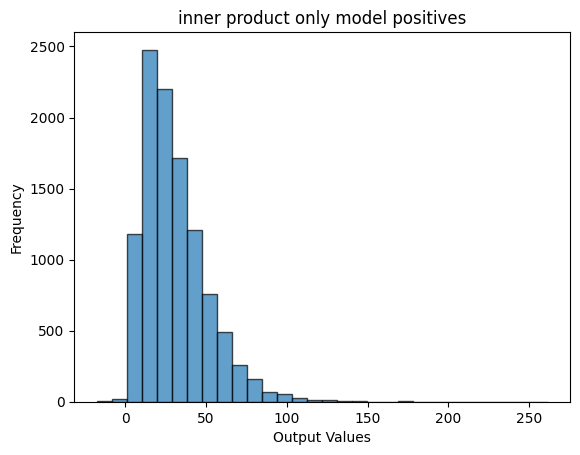

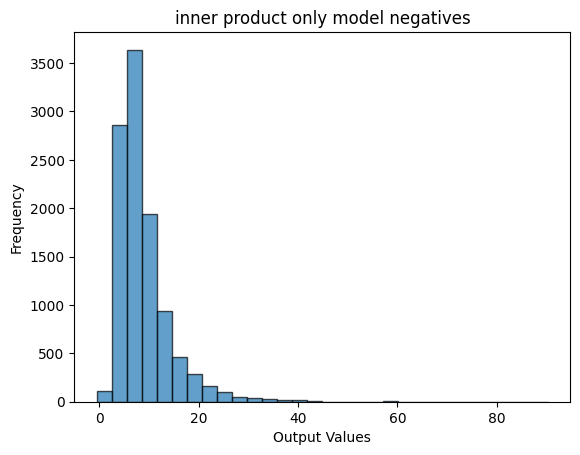

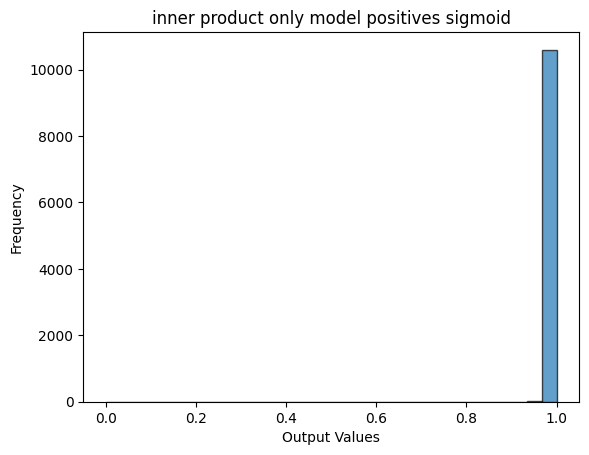

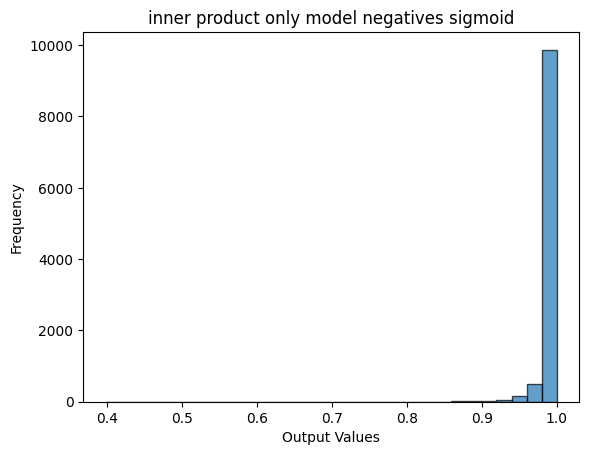

In [ ]:
plot_histogram(o[:o.shape[0]//2], "inner product only model positives")
plot_histogram(o[o.shape[0]//2:], "inner product only model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "inner product only model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "inner product only model negatives sigmoid")

In [ ]:
positives = o[:o.shape[0]//2]
negatives = o[o.shape[0]//2:]

pacc = (positives >= 0).float().sum() / positives.shape[0]
nacc = (negatives < 0).float().sum() / negatives.shape[0]
pacc * 0.5 + nacc*0.5

tensor(0.5114)

In [ ]:
free_cuda_memory(model)

# Decision boundary

based on the diagram above, we decided to define the decision boundary of 0.7


In [ ]:
save_model(model, datasets_path, "StyleMind-GCN, only inner product of embedding are used.")

NameError: name 'save_model' is not defined

#Adding bias to sigmoid inputs

In [30]:
import copy

In [46]:
model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
for epoch in range(NUM_EPOCHS):

    data_splits = get_data_splits(5)
    train_loss = train(model, x, data_splits['train']['message_passings'].to(device)
    , data_splits['train']['outfits_edge_indices'].to(device),
      data_splits['train']['outfits_indices'].to(device), data_splits['train']['labels'].to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(model, x, data_splits['train']['message_passings'].to(device)
    , data_splits['train']['outfits_edge_indices'].to(device),
      data_splits['train']['outfits_indices'].to(device), data_splits['train']['labels'].to(device))
    valid_acc = test(model, x, data_splits['valid']['message_passings'].to(device)
    , data_splits['valid']['outfits_edge_indices'].to(device),
      data_splits['valid']['outfits_indices'].to(device), data_splits['valid']['labels'].to(device))
    test_acc = test(model, x, data_splits['test']['message_passings'].to(device)
    , data_splits['test']['outfits_edge_indices'].to(device),
      data_splits['test']['outfits_indices'].to(device), data_splits['test']['labels'].to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


Epoch: 00, Loss: 27.0799, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 01, Loss: 4234.3574, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 02, Loss: 282.2950, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 03, Loss: 920.1784, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 04, Loss: 2420.0410, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 05, Loss: 1713.6787, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 06, Loss: 415.4286, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 07, Loss: 34.4208, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 08, Loss: 646.2957, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 09, Loss: 1198.0325, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 10, Loss: 1014.1862, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 11, Loss: 415.4596, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 12, Loss: 38.2327, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 13, Loss: 155.4066, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 14, Loss: 497.7525, Train

KeyboardInterrupt: 

In [ ]:
best_test_acc

tensor(0.9144, device='cuda:0')

In [ ]:
save_model(best_model, datasets_path, "StyleMind-GCN_biased_outputs.pth")

In [ ]:
model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=True).to(device)

model.load_state_dict(torch.load(path.join(datasets_path, "StyleMind-GCN_biased_outputs.pth")))

<All keys matched successfully>

In [ ]:
datasplit = data_splits()

test_acc = test(model, x, datasplit['test']['message_passings'].to(device)
    , datasplit['test']['outfits'].to(device), datasplit['test']['labels'].to(device))
embd, o = model(x, datasplit['test']['message_passings'].to(device)
    , datasplit['test']['outfits'].to(device))
embd= embd.cpu()
o = o.cpu()

print(test_acc)

tensor(0.9126, device='cuda:0')


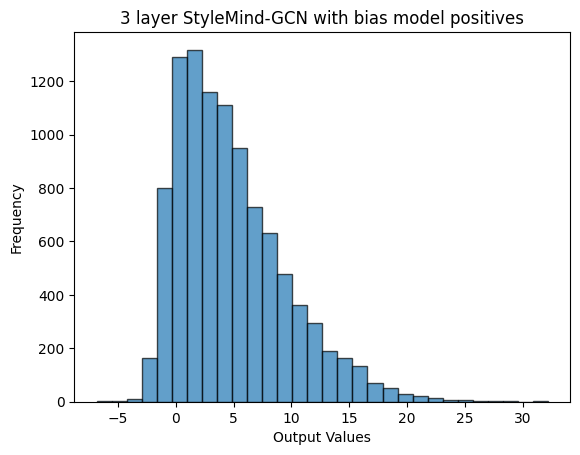

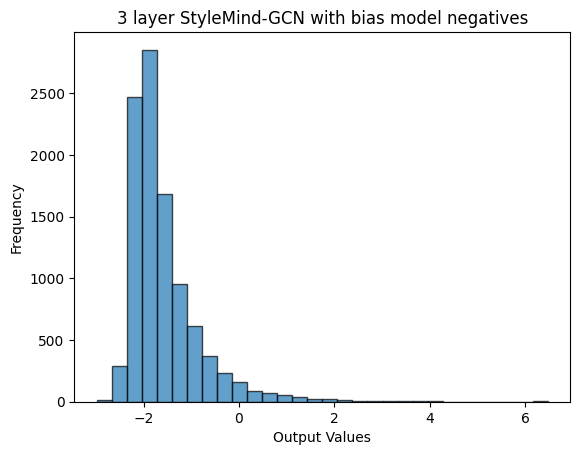

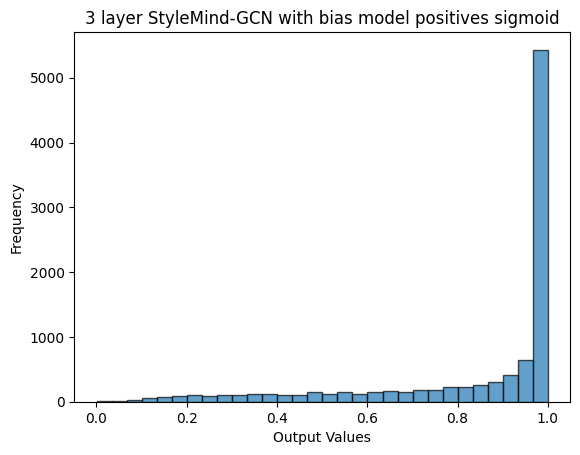

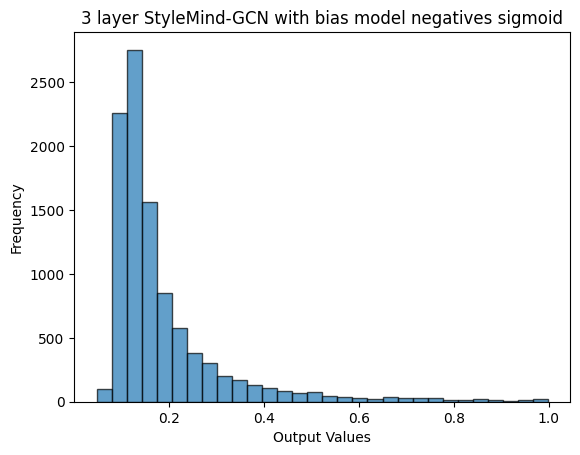

In [ ]:
plot_histogram(o[:o.shape[0]//2], "3 layer StyleMind-GCN with bias model positives")
plot_histogram(o[o.shape[0]//2:], "3 layer StyleMind-GCN with bias model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "3 layer StyleMind-GCN with bias model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "3 layer StyleMind-GCN with bias model negatives sigmoid")

In [ ]:
torch.save(embd, path.join(datasets_path, "StyleMind-GCN_embedding.pth"))

NameError: name 'embd' is not defined

In [ ]:
# the worst false negatives
values, indices = torch.topk(negatives, 10, largest=True)

outfits = train_eval_outfits[(o.shape[0]//2)+indices][torch.where(train_eval_outfits[(o.shape[0]//2)+indices]>-1)]
number_of_garments_per_outfit = (train_eval_outfits[o.shape[0]//2+indices]>-1).float().sum(dim=(-1,-2))

outfits, number_of_garments_per_outfit
i = 0
result = []
for j in number_of_garments_per_outfit.int():
  result.append(set(outfits[i:i+j].tolist()))
  i += j

result = {k: [items.loc[items['index']==i]['ID'].item() for i in o]  for k,o in enumerate(result)}

import json

with open("worstFPs.json", "w") as f:
  json.dump(result, f, indent=4)

In [ ]:
import json

# Read JSON from a file
with open("worstFPs.json", "r") as file:
    data = json.load(file)

print("JSON data:", data)


JSON data: {'0': [45768566, 143354527, 206299484, 183302521, 183236812], '1': [170301920, 132033877, 187498982, 158839785, 187950596, 191998015], '2': [80360383, 74588000, 126859205, 138180455, 205836766], '3': [41730249, 147883331, 147411023, 150737564, 189846447], '4': [161599256, 201458859, 68105585, 165502261, 150091405, 164826821, 101837389, 173597815], '5': [190811204, 145397682, 204542257, 211682911, 203154762], '6': [212764580, 150675438, 151380680, 179988294, 181104358], '7': [210473563, 167057560, 134389933, 65090075, 186155013, 127684739], '8': [197305654, 150495323, 132068063, 138667859, 174348662], '9': [166373789, 178782478, 212809241, 197241787, 157974990, 102523727, 47352111, 181333601]}


In [ ]:
# the worst false positives
values, indices = torch.topk(positives, 10, largest=False)

outfits = train_eval_outfits[indices][torch.where(train_eval_outfits[indices]>-1)]
number_of_garments_per_outfit = (train_eval_outfits[indices]>-1).float().sum(dim=(-1,-2))

outfits, number_of_garments_per_outfit
i = 0
result = []
for j in number_of_garments_per_outfit.int():
  result.append(set(outfits[i:i+j].tolist()))
  i += j

result = {k: [items.loc[items['index']==i]['ID'].item() for i in o]  for k,o in enumerate(result)}

import json

with open("worstFNs.json", "w") as f:
  json.dump(result, f, indent=4)

In [ ]:
ss = torch.randn(10).to(device)


a = set(ss.tolist())
a

{-0.9159104824066162,
 -0.3835882246494293,
 -0.30730435252189636,
 -0.17330965399742126,
 -0.16745677590370178,
 0.44133099913597107,
 0.7212685942649841,
 0.9103254675865173,
 0.9919949173927307,
 1.2212848663330078}

In [ ]:
# the worst false positives

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

# train model with cosine similarities. (instead of simple inner product).

### the result are the same and the model is not certain about negative samples. in the other word the model, embeds the nodes, such that the negative samples are orthogonal in total.

## Pros:
  - faster convergance

##Cons:
  - more memory consuming.

In [ ]:
model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
for epoch in range(400):

    train_positives_eval_outfits, message_passing_edges = split_train_data(train_edge_index[:int(0.8*train_edge_index.shape[0])], 8)
    train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
    train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                              torch.zeros(train_negatives_eval_outfits.shape[0])))
    train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
    train_loss = train(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(model, x, message_passing_edges.to(device)
    , train_eval_outfits.to(device), train_labels.to(device))


    valid_message_passing_edges = torch.cat((concat_edge_indices(train_positives_eval_outfits)
    , message_passing_edges), dim=-1)
    valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))
    valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
    valid_acc = test(model, x, valid_message_passing_edges.to(device)
    , valid_eval_outfits.to(device), valid_labels.to(device))



    test_message_passing_edges = torch.cat((concat_edge_indices(valid_edge_index)
    , valid_message_passing_edges), dim=-1)
    test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                              torch.zeros(test_negative_samples.shape[0])))
    test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
    test_acc = test(model, x, test_message_passing_edges.to(device)
    , test_eval_outfits.to(device), test_labels.to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_model = copy.deepcopy(model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


Epoch: 00, Loss: 0.7318, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 01, Loss: 0.7169, Train: 50.00%, Valid: 50.00% Test: 49.99%
Epoch: 02, Loss: 0.6912, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 03, Loss: 0.6817, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 04, Loss: 0.6740, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 05, Loss: 0.6656, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 06, Loss: 0.6569, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 07, Loss: 0.6459, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 08, Loss: 0.6404, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 09, Loss: 0.6362, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 10, Loss: 0.6301, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 11, Loss: 0.6255, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 12, Loss: 0.6209, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 13, Loss: 0.6189, Train: 50.00%, Valid: 50.00% Test: 50.00%
Epoch: 14, Loss: 0.6142, Train: 50.00%, Valid: 50.00% Test: 50

KeyboardInterrupt: 

In [ ]:
best_test_acc

tensor(0.7587, device='cuda:0')

In [ ]:
# (x / x.norm(dim=-1).min())
x.normalize()

RuntimeError: The size of tensor a (2048) must match the size of tensor b (251008) at non-singleton dimension 1

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
m = x[:100].cpu()
m

tensor([[0.2134, 0.4643, 0.3334,  ..., 0.3668, 0.0379, 0.0898],
        [0.5982, 0.7184, 0.2694,  ..., 0.2122, 0.6592, 0.0720],
        [0.3819, 4.5064, 0.2355,  ..., 0.2252, 0.7095, 0.4182],
        ...,
        [0.4332, 1.0498, 0.8459,  ..., 0.1372, 0.1394, 0.4783],
        [0.2474, 0.4604, 0.6189,  ..., 0.0801, 0.5642, 1.3976],
        [1.7186, 0.4958, 0.3872,  ..., 0.2463, 0.6565, 0.0996]])

In [ ]:
get_node_embedding_with_mask_meaningless_edge_index_elements(x.cpu(), train_eval_outfits[:100])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_test_acc.item()

0.757099986076355

In [ ]:
def save_model(model, data_path, name):
  torch.save(model.state_dict(), path.join(data_path,name))

In [ ]:
save_model(best_model, datasets_path, "best_gcn_model_based_with_cosine.pth")
save_model(model, datasets_path, "last_gcn_model_based_with_cosine.pth")

In [ ]:
model.load_state_dict(torch.load(path.join(datasets_path,"last_gcn_model_based_with_cosine.pth")))

<All keys matched successfully>

In [ ]:
negative_train_edge_index.shape

torch.Size([53306, 2, 171])

In [ ]:
train_acc = test(model, x, message_passing_edges.to(device)
, train_eval_outfits.to(device), train_labels.to(device))

In [ ]:
embd, o = model(x, test_message_passing_edges.to(device)
, train_eval_outfits[14000:].to(device))

embd = embd.cpu()
o = o.cpu()



In [ ]:
train_eval_outfits[14000:][18]

tensor([[205458, 205458,  53235,  42435,  42435,  42435,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,    

In [ ]:
items.loc[items['index'].isin([205458,  53235,  42435,9357])]

,Unnamed: 0,index,ID,url_name,description,catgeories,title,related,category_id,semantic_category,name_len
9357,9357,9357,213438505,fabulous in pink cluster earrings,NaN,NaN,NaN,NaN,11,jewellery,33
42435,42435,42435,35211694,notte marchesa silk-chiffon silk-organza halte...,NaN,NaN,NaN,NaN,1,all-body,51
53235,53235,53235,208070724,espadrilles with lacing 29.99,Yellow. Satin sandals with an adjustable strap...,"[""Women's Fashion"", 'Shoes', 'Sandals']",Sandals $24.99,"['Flats sandals', 'Yellow sandals', 'Rubber so...",6,shoes,29
205458,205458,205458,153558426,dolce gabbana sicily von crystal,NaN,NaN,NaN,NaN,5,bags,32


In [ ]:
torch.argmin(o)

tensor(3439)

In [ ]:
torch.argmax(o)

tensor(7257)

In [ ]:
indices = (o > 0.8).nonzero(as_tuple=True)
indices

(tensor([  18,  132,  159,  259,  439,  513,  711,  796, 1006, 1008, 1347, 1401,
         1462, 1580, 1594, 1630, 1647, 1692, 1772, 1790, 1825, 1841, 1905, 2251,
         2558, 2564, 2727, 2854, 3030, 3210, 3472, 3551, 3873, 4045, 4159, 4199,
         4279, 4412, 4535, 4649, 5113, 5183, 5217, 5224, 5333, 5385, 5436, 5480,
         5538, 5794, 5858, 5886, 5900, 5924, 6022, 6092, 6146, 6390, 6449, 6495,
         6498, 6562, 6634, 6776, 7019, 7092, 7257, 7272, 7309]),)

In [ ]:
o.shape, (o[o<0.5]).shape

(torch.Size([7322]), torch.Size([3653]))

In [ ]:
train_eval_outfits.shape

torch.Size([21322, 2, 171])

In [ ]:
node_embeddigns, o = best_model(x, test_message_passing_edges.to(device), test_eval_outfits.to(device))

o.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.60 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.51 GiB is free. Process 69290 has 13.23 GiB memory in use. Of the allocated memory 11.11 GiB is allocated by PyTorch, and 1.99 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

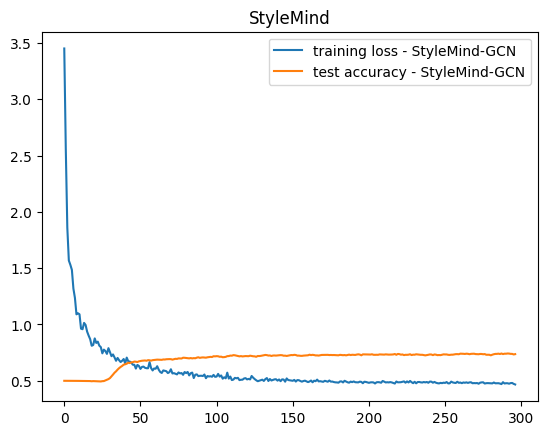

In [ ]:

plt.title("StyleMind")
plt.plot(losses[3:], label="training loss" + " - " + "StyleMind-GCN")
plt.plot(test_accs[3:], label="test accuracy" + " - " + "StyleMind-GCN")
plt.legend()
plt.show()


In [ ]:
hidden_channel = 128
out_channel = 128
number_of_layers = 3
dropout = 0.5
lr = 0.01
mlp_model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"MLP", dropout, learning_margin=True).to(device)

In [ ]:
from tqdm import tqdm

In [ ]:
mlp_model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(mlp_model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
datasplit = data_splits(1)


dataset = TensorDataset(datasplit['train']['outfits'], datasplit['train']['labels'])
dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)

for epoch in range(100,400):
  for batch_idx, (batch_data, batch_labels) in enumerate(tqdm(dataloader, desc='Processing Batches')):
      batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
      train_loss = train(mlp_model, x, datasplit['train']['message_passings'].to(device)
      , batch_data, batch_labels,
                       loss_fn=loss_fn, optimizer=optimizer)

  train_acc = test(mlp_model, x, datasplit['train']['message_passings'].to(device)
  , batch_data, batch_labels)
  valid_acc = test(mlp_model, x, datasplit['valid']['message_passings'].to(device)
  , datasplit['valid']['outfits'].to(device), datasplit['valid']['labels'].to(device))
  test_acc = test(mlp_model, x, datasplit['test']['message_passings'].to(device)
  , datasplit['test']['outfits'].to(device), datasplit['test']['labels'].to(device))

  if(test_acc > best_test_acc):
      best_test_acc = test_acc
      best_model = copy.deepcopy(mlp_model)

  losses.append(train_loss)
  test_accs.append(test_acc)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {train_loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.43s/it]


Epoch: 100, Loss: 0.4454, Train: 79.39%, Valid: 79.27% Test: 79.81%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.36s/it]


Epoch: 101, Loss: 0.4263, Train: 79.30%, Valid: 79.67% Test: 79.71%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 102, Loss: 0.4295, Train: 78.96%, Valid: 78.91% Test: 79.31%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 103, Loss: 0.4259, Train: 80.10%, Valid: 79.54% Test: 80.05%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 104, Loss: 0.4328, Train: 79.75%, Valid: 79.20% Test: 79.59%


Processing Batches: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch: 105, Loss: 0.4219, Train: 79.43%, Valid: 78.90% Test: 79.38%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 106, Loss: 0.4279, Train: 79.76%, Valid: 79.90% Test: 79.85%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 107, Loss: 0.4200, Train: 80.31%, Valid: 79.41% Test: 79.41%


Processing Batches: 100%|██████████| 11/11 [00:25<00:00,  2.35s/it]


Epoch: 108, Loss: 0.4200, Train: 79.85%, Valid: 79.78% Test: 80.03%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 109, Loss: 0.4306, Train: 79.28%, Valid: 79.33% Test: 79.50%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 110, Loss: 0.4239, Train: 79.13%, Valid: 79.97% Test: 80.25%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 111, Loss: 0.4409, Train: 79.10%, Valid: 79.30% Test: 79.97%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 112, Loss: 0.4164, Train: 79.92%, Valid: 79.86% Test: 80.25%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch: 113, Loss: 0.4405, Train: 79.22%, Valid: 79.99% Test: 79.96%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.36s/it]


Epoch: 114, Loss: 0.4353, Train: 79.70%, Valid: 79.33% Test: 79.70%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it]


Epoch: 115, Loss: 0.4162, Train: 80.29%, Valid: 79.96% Test: 80.19%


Processing Batches: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch: 116, Loss: 0.4279, Train: 80.57%, Valid: 79.22% Test: 79.98%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


Epoch: 117, Loss: 0.4151, Train: 80.72%, Valid: 79.98% Test: 80.14%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 118, Loss: 0.4319, Train: 79.39%, Valid: 79.13% Test: 79.62%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch: 119, Loss: 0.4194, Train: 80.40%, Valid: 79.16% Test: 80.01%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 120, Loss: 0.4281, Train: 79.99%, Valid: 78.76% Test: 79.28%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 121, Loss: 0.4228, Train: 79.93%, Valid: 79.73% Test: 79.69%


Processing Batches: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch: 122, Loss: 0.4186, Train: 80.26%, Valid: 79.58% Test: 79.39%


Processing Batches: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch: 123, Loss: 0.4268, Train: 79.60%, Valid: 79.86% Test: 79.78%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 124, Loss: 0.4265, Train: 79.63%, Valid: 78.68% Test: 79.53%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 125, Loss: 0.4177, Train: 79.67%, Valid: 79.69% Test: 79.55%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 126, Loss: 0.4120, Train: 80.46%, Valid: 80.59% Test: 79.93%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 127, Loss: 0.4159, Train: 80.20%, Valid: 79.35% Test: 78.99%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 128, Loss: 0.4191, Train: 80.25%, Valid: 80.19% Test: 80.84%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 129, Loss: 0.4086, Train: 80.60%, Valid: 79.52% Test: 79.44%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 130, Loss: 0.4099, Train: 80.78%, Valid: 79.77% Test: 79.91%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 131, Loss: 0.4103, Train: 81.67%, Valid: 79.40% Test: 80.19%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it]


Epoch: 132, Loss: 0.4066, Train: 81.17%, Valid: 79.28% Test: 79.57%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 133, Loss: 0.4116, Train: 80.02%, Valid: 79.67% Test: 79.88%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 134, Loss: 0.4095, Train: 79.84%, Valid: 79.19% Test: 79.82%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 135, Loss: 0.4050, Train: 80.96%, Valid: 80.23% Test: 80.14%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 136, Loss: 0.4127, Train: 80.52%, Valid: 79.54% Test: 79.89%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 137, Loss: 0.3979, Train: 80.52%, Valid: 79.43% Test: 79.42%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 138, Loss: 0.4013, Train: 80.26%, Valid: 79.47% Test: 80.43%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch: 139, Loss: 0.3964, Train: 81.53%, Valid: 79.22% Test: 79.78%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 140, Loss: 0.3993, Train: 81.61%, Valid: 79.50% Test: 80.22%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch: 141, Loss: 0.4079, Train: 80.11%, Valid: 78.30% Test: 78.51%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 142, Loss: 0.3975, Train: 80.20%, Valid: 79.54% Test: 80.19%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch: 143, Loss: 0.3960, Train: 81.26%, Valid: 79.84% Test: 79.89%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.36s/it]


Epoch: 144, Loss: 0.4013, Train: 80.31%, Valid: 78.52% Test: 79.11%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 145, Loss: 0.3945, Train: 81.78%, Valid: 80.23% Test: 80.38%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 146, Loss: 0.4142, Train: 80.87%, Valid: 79.85% Test: 79.99%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it]


Epoch: 147, Loss: 0.3963, Train: 80.29%, Valid: 79.40% Test: 79.88%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


Epoch: 148, Loss: 0.3962, Train: 81.00%, Valid: 80.10% Test: 79.83%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch: 149, Loss: 0.4063, Train: 81.70%, Valid: 80.00% Test: 79.81%


Processing Batches: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch: 150, Loss: 0.3993, Train: 81.17%, Valid: 80.03% Test: 79.84%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it]


Epoch: 151, Loss: 0.3842, Train: 81.84%, Valid: 79.26% Test: 79.71%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 152, Loss: 0.3940, Train: 81.05%, Valid: 79.63% Test: 79.96%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


Epoch: 153, Loss: 0.3882, Train: 81.02%, Valid: 79.40% Test: 79.59%


Processing Batches: 100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


Epoch: 154, Loss: 0.3910, Train: 80.75%, Valid: 79.04% Test: 79.46%


Processing Batches: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch: 155, Loss: 0.3977, Train: 80.55%, Valid: 78.28% Test: 78.58%


Processing Batches:   9%|▉         | 1/11 [00:05<00:50,  5.10s/it]


KeyboardInterrupt: 

In [ ]:
best_test_acc

tensor(0.8084, device='cuda:0')

## Best Test Accuracy = 0.808

In [ ]:
embd, o = best_model(x, datasplit['test']['message_passings'].to(device)
  , datasplit['test']['outfits'].to(device))

embd = embd.cpu()
o = o.cpu()

In [ ]:
torch.save(embd, path.join(datasets_path, "mlp_embedding.pth"))

In [ ]:
best_model.final_prediction_margin

Parameter containing:
tensor(-1.8305, device='cuda:0', requires_grad=True)

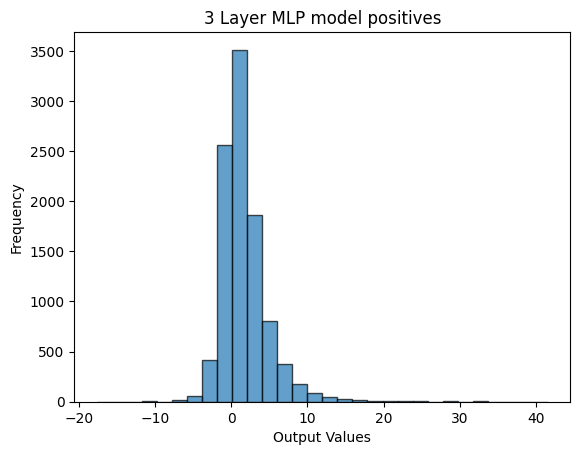

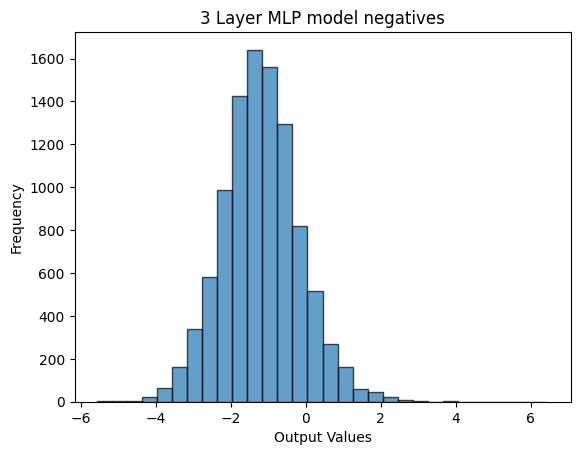

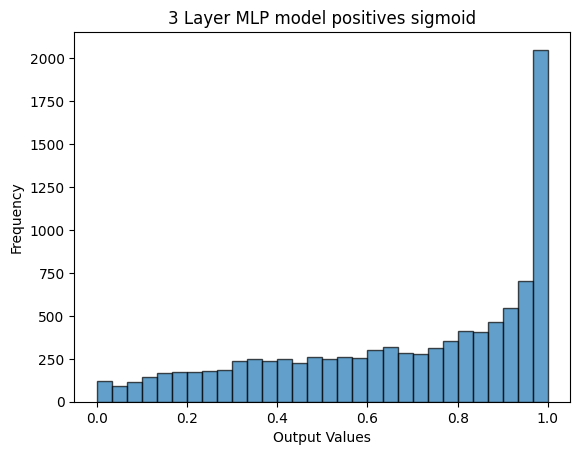

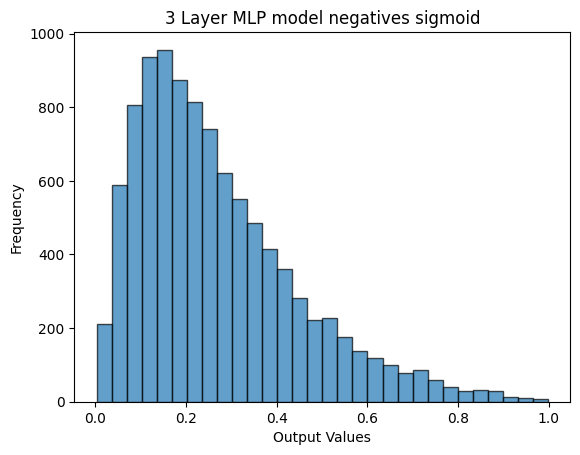

In [ ]:
plot_histogram(o[:o.shape[0]//2], "3 Layer MLP model positives")
plot_histogram(o[o.shape[0]//2:], "3 Layer MLP model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "3 Layer MLP model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "3 Layer MLP model negatives sigmoid")

In [ ]:
save_model(best_model, datasets_path, "MLP_model.pth")

#StyleMind-GAT

In [ ]:
hidden_channels = 128
in_channels = x.shape[-1]
out_channels = 128
number_of_layers = 3
dropout = 0.5
lr = 0.01
gat_model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GAT", dropout, learning_margin=True).to(device)

In [ ]:
gat_model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(gat_model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)

for epoch in range(400,800):
    datasplit = data_splits(10)
    train_loss = train(gat_model, x, datasplit['train']['message_passings'].to(device)
    , datasplit['train']['outfits'].to(device), datasplit['train']['labels'].to(device),
                      loss_fn=loss_fn, optimizer=optimizer)

    train_acc = test(gat_model, x, datasplit['train']['message_passings'].to(device)
    , datasplit['train']['outfits'].to(device), datasplit['train']['labels'].to(device))
    valid_acc = test(gat_model, x, datasplit['valid']['message_passings'].to(device)
    , datasplit['valid']['outfits'].to(device), datasplit['valid']['labels'].to(device))
    test_acc = test(gat_model, x, datasplit['test']['message_passings'].to(device)
    , datasplit['test']['outfits'].to(device), datasplit['test']['labels'].to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_model = copy.deepcopy(gat_model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


Epoch: 400, Loss: 0.3125, Train: 87.85%, Valid: 76.63% Test: 81.88%
Epoch: 401, Loss: 0.3143, Train: 87.84%, Valid: 76.52% Test: 81.76%
Epoch: 402, Loss: 0.3137, Train: 87.57%, Valid: 76.83% Test: 81.52%
Epoch: 403, Loss: 0.3104, Train: 87.62%, Valid: 77.08% Test: 81.72%
Epoch: 404, Loss: 0.3176, Train: 87.13%, Valid: 77.52% Test: 81.74%
Epoch: 405, Loss: 0.3047, Train: 87.66%, Valid: 76.78% Test: 81.68%
Epoch: 406, Loss: 0.3103, Train: 87.90%, Valid: 76.29% Test: 81.68%
Epoch: 407, Loss: 0.3098, Train: 88.22%, Valid: 76.00% Test: 81.75%
Epoch: 408, Loss: 0.3062, Train: 88.24%, Valid: 76.68% Test: 81.84%
Epoch: 409, Loss: 0.3065, Train: 87.98%, Valid: 77.48% Test: 81.95%
Epoch: 410, Loss: 0.3129, Train: 87.87%, Valid: 77.42% Test: 82.23%
Epoch: 411, Loss: 0.3115, Train: 87.43%, Valid: 77.41% Test: 82.29%
Epoch: 412, Loss: 0.3084, Train: 87.35%, Valid: 77.55% Test: 81.95%
Epoch: 413, Loss: 0.3154, Train: 87.63%, Valid: 77.28% Test: 82.00%
Epoch: 414, Loss: 0.2983, Train: 88.01%, Valid: 

In [ ]:
best_test_acc

tensor(0.8943, device='cuda:0')

In [ ]:
embd, o = best_model(x, datasplit['test']['message_passings'].to(device)
    , datasplit['test']['outfits'].to(device))

embd = embd.cpu()
o = o.cpu()

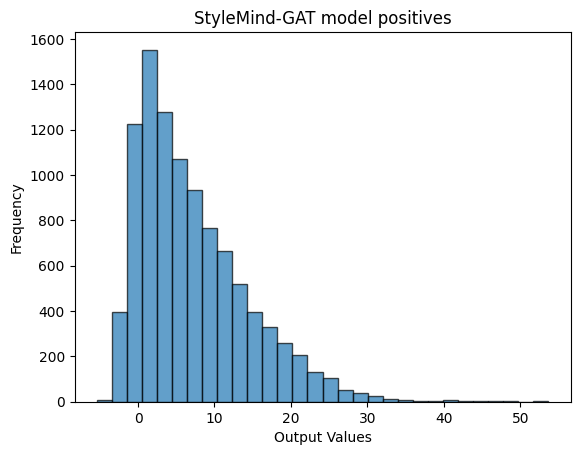

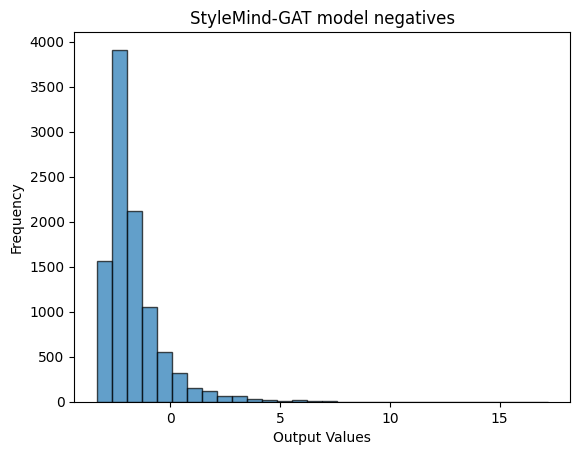

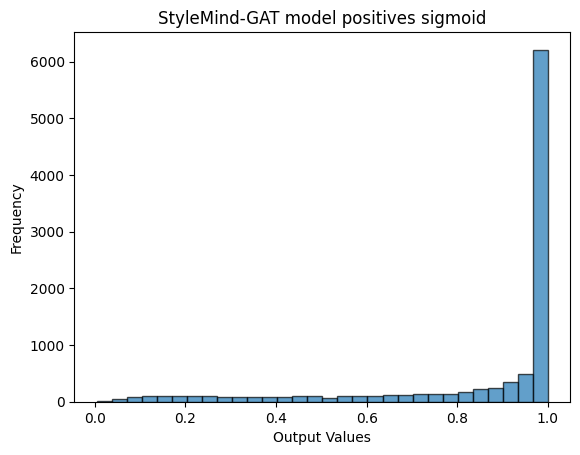

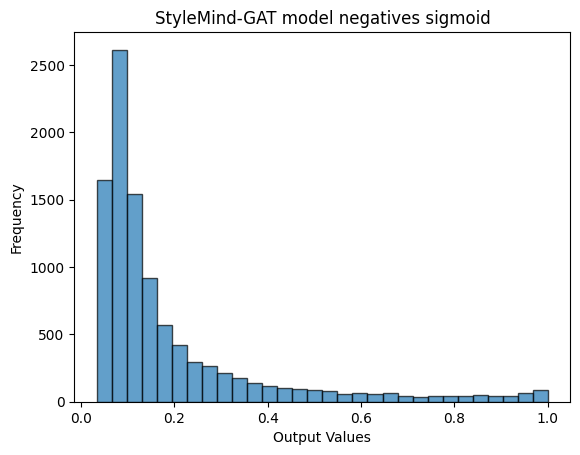

In [ ]:
plot_histogram(o[:o.shape[0]//2], "StyleMind-GAT model positives")
plot_histogram(o[o.shape[0]//2:], "StyleMind-GAT model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "StyleMind-GAT model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "StyleMind-GAT model negatives sigmoid")

In [ ]:
save_model(best_model, datasets_path, "StyleMind-GAT.pth")

In [ ]:
torch.save(embd, path.join(datasets_path, "StyleMind-GAT_embeddings.pth"))

In [ ]:
free_cuda_memory(gat_model)
gc.collect()
torch.cuda.empty_cache()